### 3.유방암 데이터로 딥러닝 분류

Epoch [  1/50] | Train Loss: 0.2868 | Val Loss: 0.1172 | Train Acc: 82.64% | Val Acc: 96.49%
Epoch [  5/50] | Train Loss: 0.0337 | Val Loss: 0.1737 | Train Acc: 98.90% | Val Acc: 95.61%
Epoch [ 10/50] | Train Loss: 0.0910 | Val Loss: 0.2076 | Train Acc: 96.26% | Val Acc: 96.49%
Epoch [ 15/50] | Train Loss: 0.0336 | Val Loss: 0.6596 | Train Acc: 99.34% | Val Acc: 95.61%
Epoch [ 20/50] | Train Loss: 0.0243 | Val Loss: 0.7121 | Train Acc: 99.12% | Val Acc: 95.61%
Epoch [ 25/50] | Train Loss: 0.0196 | Val Loss: 0.7301 | Train Acc: 99.34% | Val Acc: 96.49%
Epoch [ 30/50] | Train Loss: 0.0169 | Val Loss: 0.7860 | Train Acc: 99.34% | Val Acc: 95.61%
Epoch [ 35/50] | Train Loss: 0.0164 | Val Loss: 0.8348 | Train Acc: 99.34% | Val Acc: 95.61%
Epoch [ 40/50] | Train Loss: 0.0213 | Val Loss: 0.9505 | Train Acc: 99.34% | Val Acc: 93.86%
Epoch [ 45/50] | Train Loss: 0.0159 | Val Loss: 0.8807 | Train Acc: 99.34% | Val Acc: 94.74%
Epoch [ 50/50] | Train Loss: 0.0114 | Val Loss: 1.0071 | Train Acc: 99

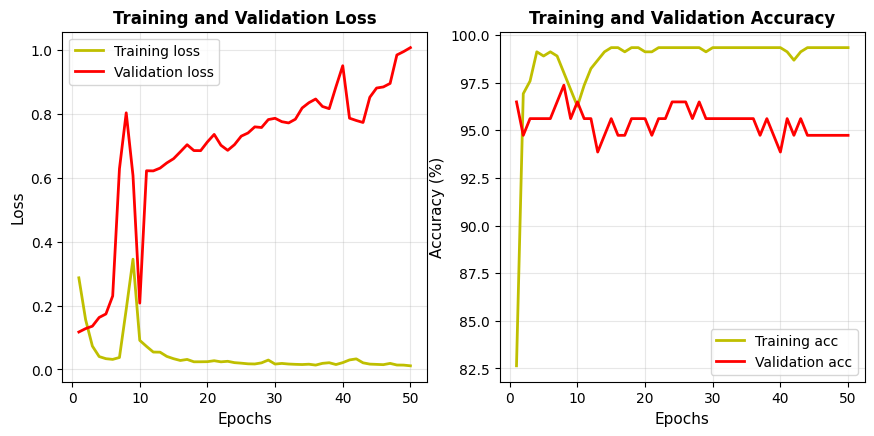

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 데이터 로딩
df = pd.read_csv("./data/breast_cancer.csv", index_col=0)

# 특성과 레이블 분리
X = df.drop('label', axis=1)
y = df['label']

# 레이블을 원-핫 인코딩
Y = pd.get_dummies(y).values

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0
)

# 데이터 정규화 (선택사항, 성능 향상을 위해 추가)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 2. FC 네트워크 모델 정의
class FCNetwork(nn.Module):
    def __init__(self):
        super(FCNetwork, self).__init__()
        
        self.fc1 = nn.Linear(30, 10)  # 입력층 → 은닉층1
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(10, 8)   # 은닉층1 → 은닉층2
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(8, 6)    # 은닉층2 → 은닉층3
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(6, 2)    # 은닉층3 → 출력층
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        x = self.softmax(x)
        
        return x
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# 3. 모델 초기화
model = FCNetwork()

# 4. 손실 함수 및 옵티마이저
criterion = nn.BCELoss()  # Binary Cross Entropy (Keras의 binary_crossentropy)
optimizer = optim.Adam(model.parameters(), lr=0.04)

# 5. 학습
epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # 훈련 모드
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 통계
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(batch_y.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # 훈련 손실 및 정확도
    avg_train_loss = epoch_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # 검증 모드
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()
        
        _, val_predicted = torch.max(val_outputs.data, 1)
        _, val_labels = torch.max(y_test_tensor.data, 1)
        val_acc = 100 * (val_predicted == val_labels).sum().item() / len(val_labels)
    
    # 기록
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # 출력
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1:3d}/{epochs}] | "
              f"Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


# 6. 최종 평가
model.eval()
with torch.no_grad():
    # 훈련 데이터 평가
    train_outputs = model(X_train_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    _, train_labels = torch.max(y_train_tensor.data, 1)
    final_train_acc = accuracy_score(train_labels.numpy(), train_predicted.numpy())
    
    # 테스트 데이터 평가
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    _, test_labels = torch.max(y_test_tensor.data, 1)
    final_test_acc = accuracy_score(test_labels.numpy(), test_predicted.numpy())

print(f"최종 훈련 정확도: {final_train_acc * 100:.2f}%")
print(f"최종 테스트 정확도: {final_test_acc * 100:.2f}%")


# 7. 시각화
fig = plt.figure(figsize=(16, 10))

# Subplot 1: Training and Validation Loss
plt.subplot(2, 3, 1)
epochs_range = range(1, len(train_losses) + 1)
plt.plot(epochs_range, train_losses, 'y', label='Training loss', linewidth=2)
plt.plot(epochs_range, val_losses, 'r', label='Validation loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Training and Validation Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs_range, train_accs, 'y', label='Training acc', linewidth=2)
plt.plot(epochs_range, val_accs, 'r', label='Validation acc', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy (%)', fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)
